In [1]:
from utils.utils import *
from utils.Algorithms import *
from utils.GraphCreation import *
from utils.Metrics import *
import pandas as pd
np.random.seed(0)

In [2]:
def runResults(matrix, true_clusters, k, algorithms, metrics):

    """
    Runs the algorithms and returns a dataframe with the results on the metrics
    
    Parameters
    ----------
    matrix (numpy.ndarray) Adjacency matrix of the graph
    true_clusters (list) List of the true clusters
    k (int) Number of target clusters
    algorithms (list) List of algorithms to run
    metrics (list) List of metrics to use

    Returns
    -------
    results (pandas.DataFrame) Dataframe with the results
    """

    results = pd.DataFrame(columns = ['Algorithm'] + [metric.__name__ for metric in metrics])

    for algorithm in algorithms:
        new_line = [algorithm.__name__] + [round(metric(algorithm(matrix, k), true_clusters), 2) for metric in metrics]
        results.loc[len(results.index)] = new_line

    results.set_index('Algorithm', inplace = True)

    return results

In [3]:
algorithms = [SC_GED, SC_SUM, SC_AL] #KKmeans et SC_SR à ajouter quand ils seront prêts (on peut déjà commencer les expérimentations)
metrics = [Purity, NMI, RI]

# Simple Two-Layer Graph

In [4]:
#On peut faire des seuils pour la connection entre potes
#par exemple
HIGH = 0.8
MEDIUM = 0.5
LOW = 0.3

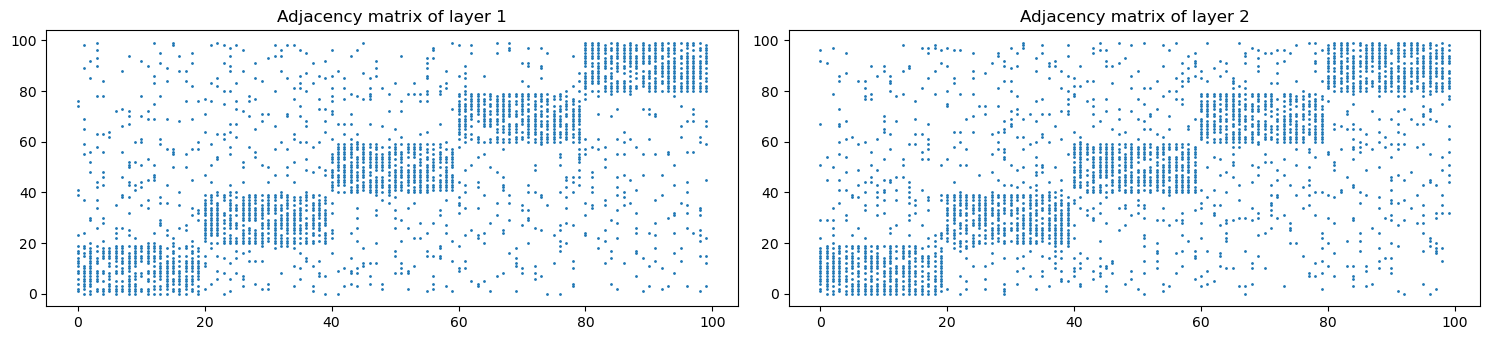

True assignment  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [5]:
n = 100
M = 2
k = 5

p = HIGH
delta = 0.7 #should be between 0 and p ; on peut le varier varier pour avoir une courbe

prob = np.full((k,M), p)
prob_prime = np.full((k,k,M), p-delta)
clusters_size = k*[20]

matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)
print("True assignment ", true_clusters)


In [6]:
#c'est le SC_GED qui prend le plus de temps
results = runResults(matrix, true_clusters, k, algorithms, metrics)
results

,Purity,NMI,RI
Algorithm,,,
SC_GED,1.0,1.0,1.0
SC_SUM,1.0,1.0,1.0
SC_AL,1.0,1.0,1.0


# More complicated

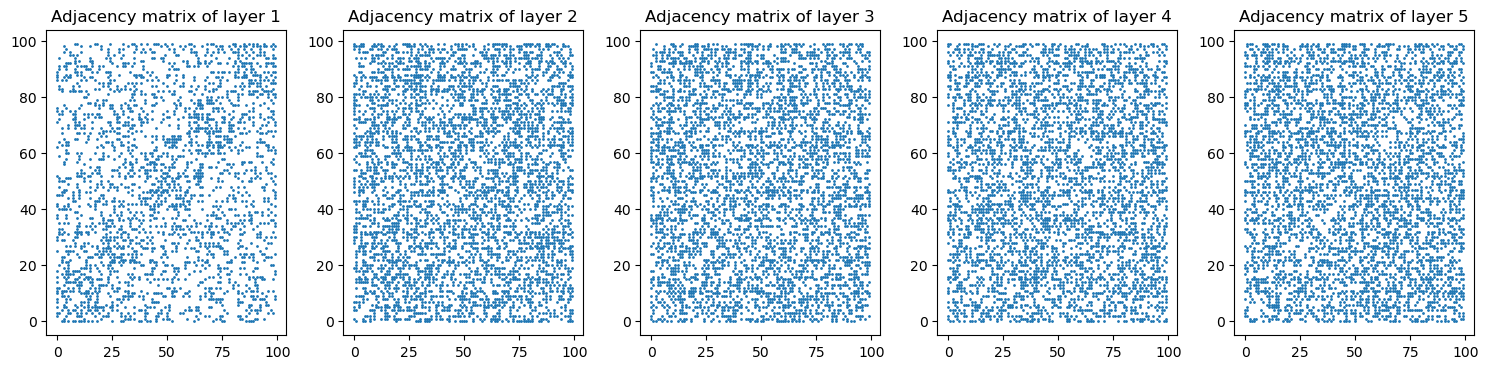

In [7]:
n = 100
M = 5
k = 5

p = MEDIUM

prob = np.full((k,M),0.4)

prob_prime1 = np.full((k,k),0.2)
prob_prime2 = np.full((k,k),0.4)
prob_prime3 = np.full((k,k),0.4)
prob_prime4 = np.full((k,k),0.4)
prob_prime5 = np.full((k,k),0.4)

prob_prime = np.stack((prob_prime1,prob_prime2, prob_prime3, prob_prime4, prob_prime5),axis=2)
clusters_size = k*[20]

matrix,index_cluster = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)

In [9]:
#2 mn 15 runtime pour 100 noeuds
results = runResults(matrix, true_clusters, k, algorithms, metrics)
results

,Purity,NMI,RI
Algorithm,,,
SC_GED,0.40,0.16,0.70
SC_SUM,0.35,0.13,0.68
SC_AL,0.44,0.18,0.71
